<div dir="rtl" lang="he" xml:lang="he">


# אימון מודל ליניארי




In [20]:
%matplotlib inline
# %matplotlib widget
from IPython import display
from torch import nn , optim
import torch
import matplotlib.pyplot as plt

from typing import Callable,List,Tuple
from torch import Tensor
from torch.nn import Module
from Tools import *
from plotly import graph_objects  as go
from plotly import subplots 

<div dir="rtl" lang="he" xml:lang="he">

# שיכבה לינארית של סקלר
שיכבה ליניארית של סקלר היא משוואה ישר פשוטה, נוכל לראות כיצד המודל שלנו מתקרב למשווה של הישר הזה. 



<div dir="rtl" lang="he" xml:lang="he">

## יצירת השיכבה

In [21]:
linear = nn.Linear(1, 1)
x = torch.rand(3, 1) * 10
print(
    f"""
{x=},
{linear(x)=}
"""
)



x=tensor([[0.2895],
        [1.0049],
        [8.1035]]),
linear(x)=tensor([[-0.6314],
        [-0.7512],
        [-1.9396]], grad_fn=<AddmmBackward0>)



In [22]:
W = linear.weight.data
b = linear.bias.data
print(
    f"""
{x=},
{W=},
{b=},
{x@W.T=},
{x@W.T+b=},
"""
)



x=tensor([[0.2895],
        [1.0049],
        [8.1035]]),
W=tensor([[-0.1674]]),
b=tensor([-0.5830]),
x@W.T=tensor([[-0.0485],
        [-0.1682],
        [-1.3566]]),
x@W.T+b=tensor([[-0.6314],
        [-0.7512],
        [-1.9396]]),




<div dir="rtl" lang="he" xml:lang="he">

## אימון המודל
בשביל לבדוק את המודל, נקח את הפונקציה הפשוטה ביותר - 
$f(x)=x$
ונרעיש אותה קצת. נראה האם המודל שלנו יצליח להתקרב מספיק למשוואה הנדרשת 
 

In [23]:
x = torch.arange(1, 11, dtype=torch.float32).unsqueeze_(1)
target = torch.empty(10, 1).uniform_(-1, 1) + x
linear = nn.Linear(1, 1)
plot_model_plotly(linear, x, target)

In [24]:
loss_function = nn.MSELoss()
optimazer = optim.SGD(linear.parameters(), 0.001)
loss_list = []
f_plot = ploter(plot_model_plotly, linear, x, target, loss_list)


In [25]:
for i in range(30):
    optimazer.zero_grad()
    y = linear(x)
    diff = loss_function(y, target)
    diff.backward()
    loss_list.append(diff.item())
    optimazer.step()
    if i % 5 == 0:
        f_plot()


<div dir="rtl" lang="he" xml:lang="he">

# מודל שמקבל בשני מימדים
כעת נוכל לבנות מודל טפה יותר מורכב, שמקבל וקטור בגודל 2.
גם פה נקח את הקורדינטות על הקו ונרעיש אותם קצת. כמה מהר המודל יצליח להתקרב מספיק למשוואה?


In [26]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.f1 = nn.Linear(2, 1)

    def __call__(self, x):
        return self.f1(x)


model = Model()
loss_function = nn.MSELoss()
optimazer = optim.SGD(model.parameters(), 0.000001)


<div dir="rtl" lang="he" xml:lang="he">

### יצירת דאטה
כמו בדוגמה הקודמת, ניצור דאטה פשוט. שהפונקציה היוצרת אותו היא מטריצת היחידה. 
נרעיש מעט את המידע שיש לנו, ונראה האם המודל מצליח לקרב את הפונקציה שלנו

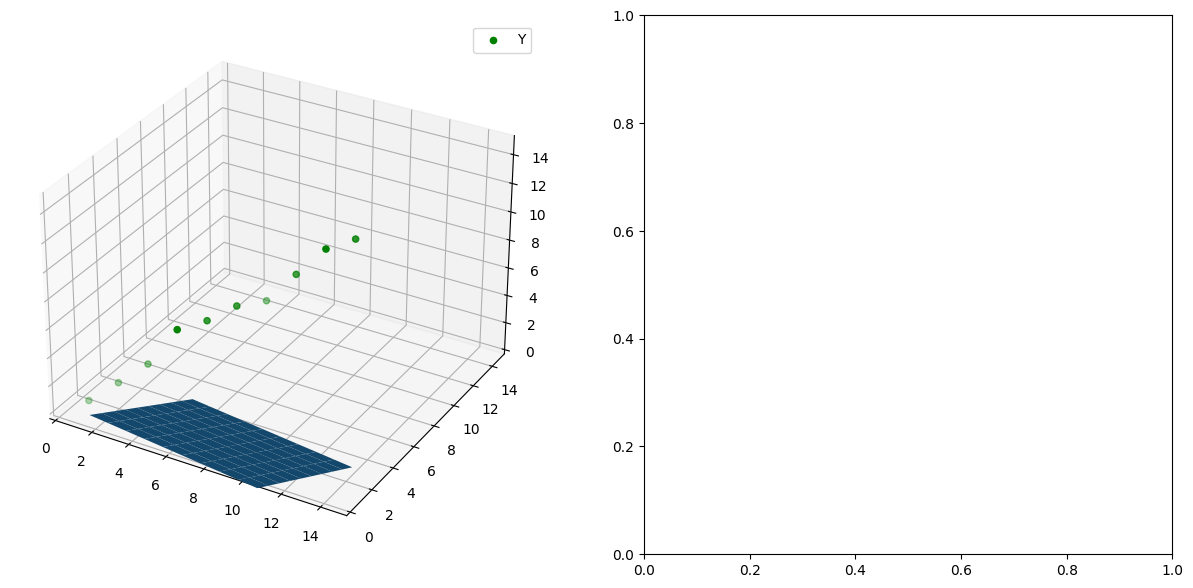

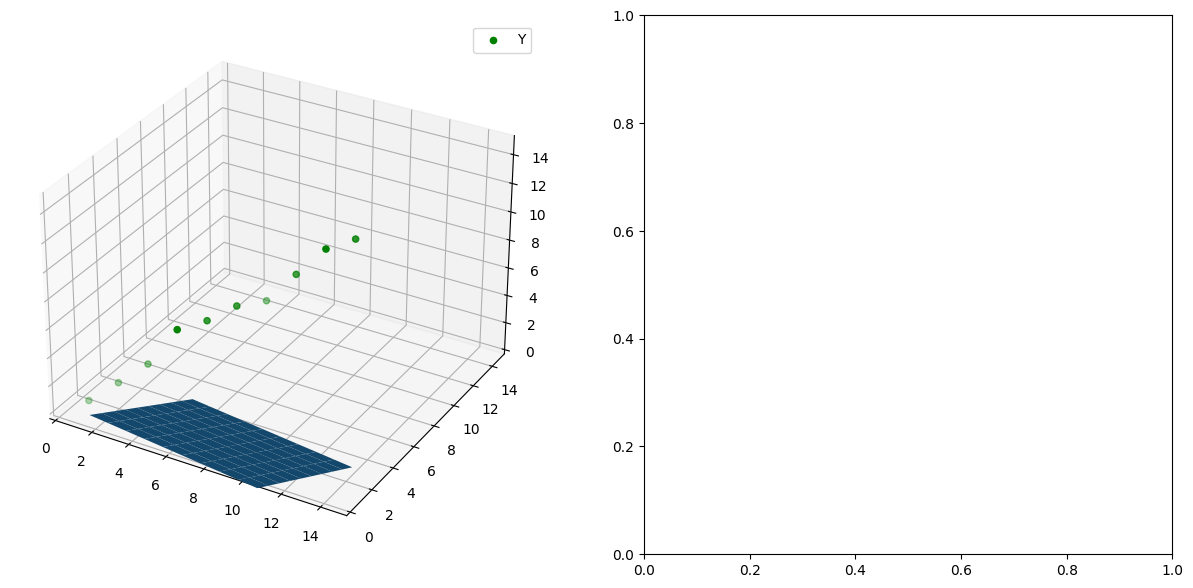

In [27]:
coordint = torch.arange(1, 11, dtype=torch.float32).unsqueeze_(1)
target = torch.empty(10, 1).uniform_(-1, 1) + coordint
input_data = torch.cat([coordint, coordint], 1)
plot_3d_model(model, input_data, target)


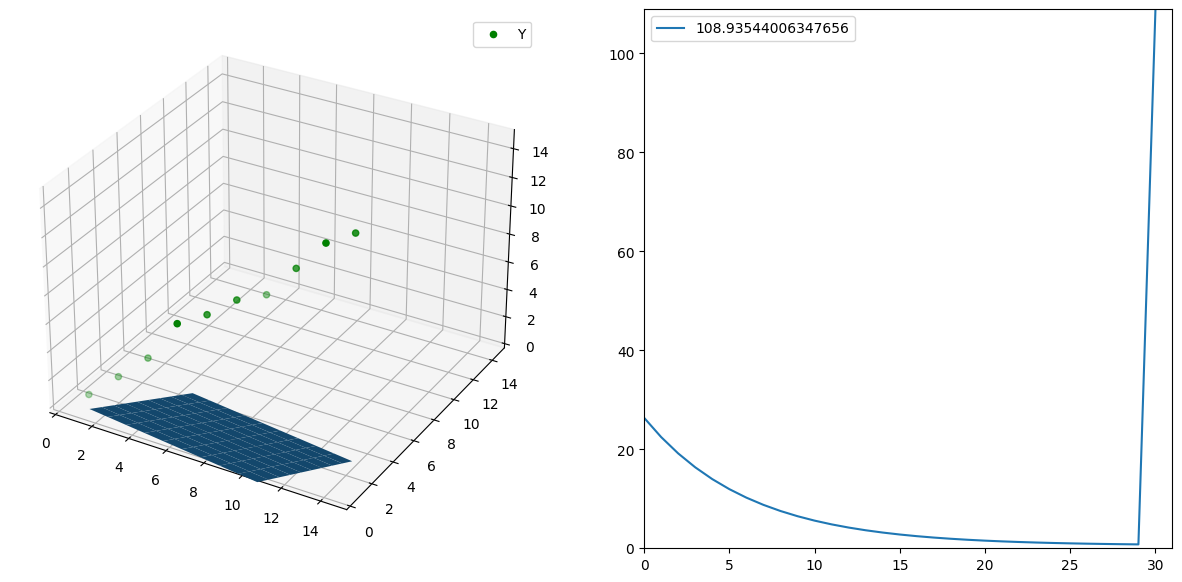

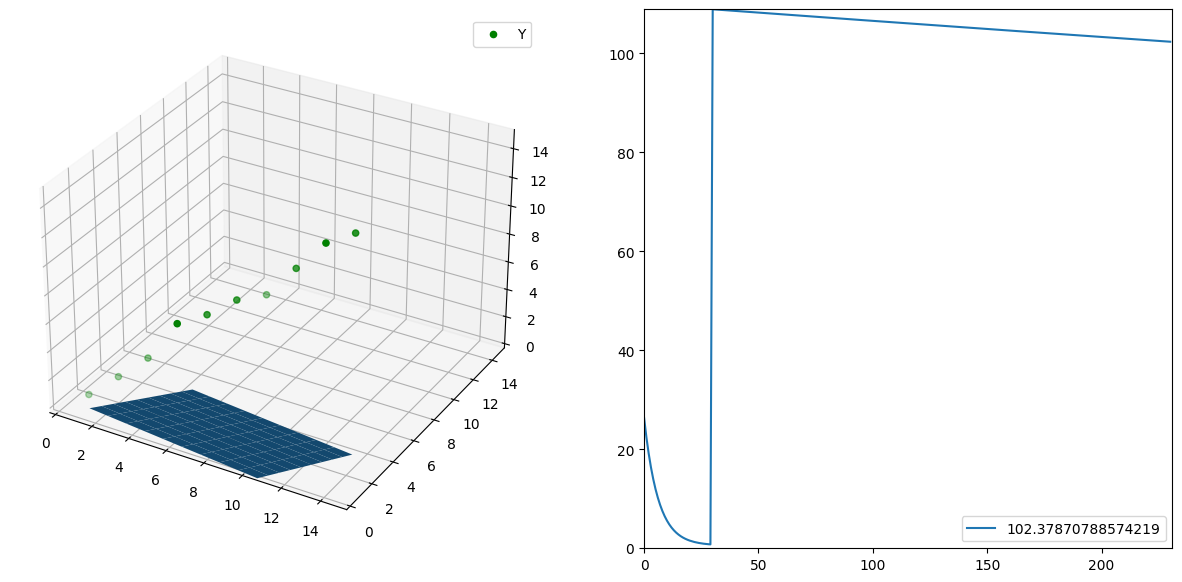

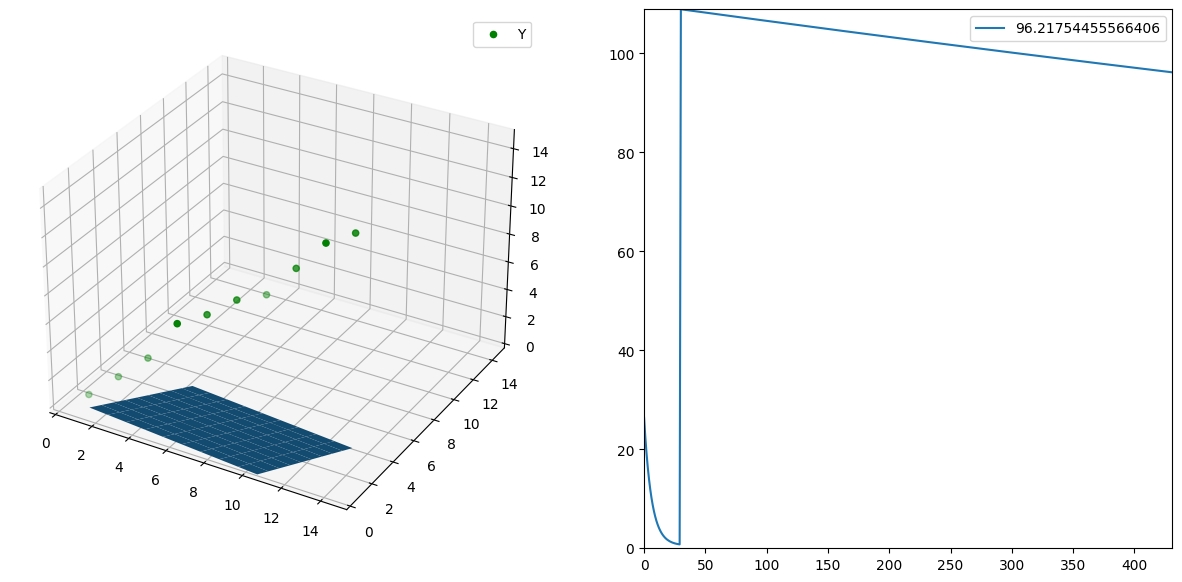

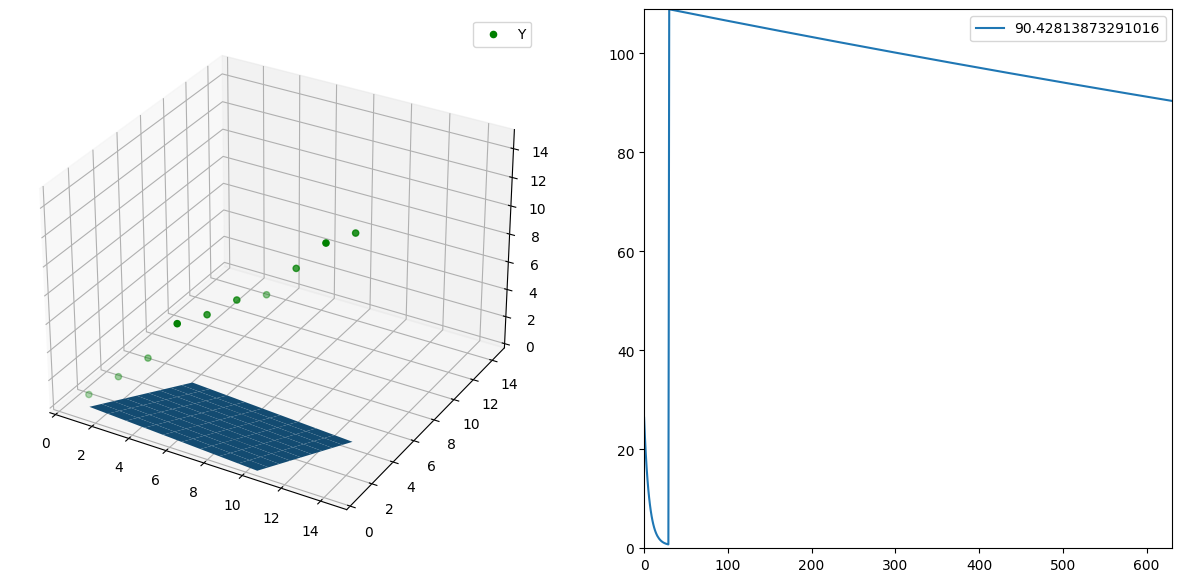

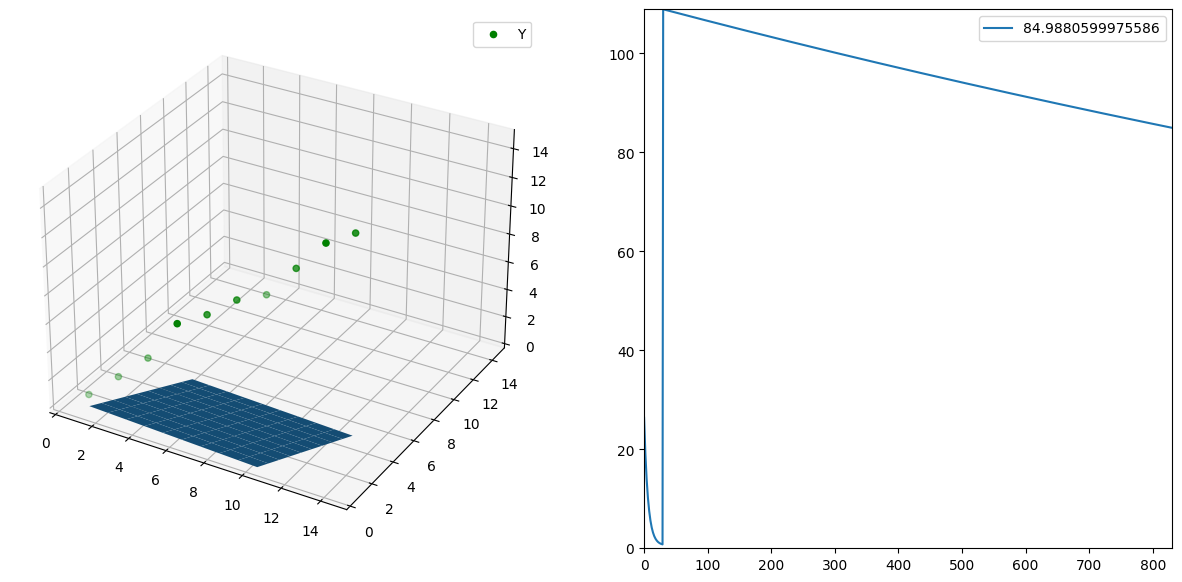

In [28]:
xloss_list = []
f_plot = ploter(plot_3d_model, model, input_data, target, loss_list)

for i in range(1000):
    optimazer.zero_grad()
    y = model(input_data)
    diff = loss_function(y, target)
    loss_list.append(diff.item())
    diff.backward()
    optimazer.step()
    if i % 200 == 0:
        f_plot()


<div dir="rtl" lang="he" xml:lang="he">

## השוואת פונקציות אופטימיזציה ופונקציות עלות
ניתן לראות במודל הקודם שתהליך הלמידה פה לא מתכנס, הוא נע בגלים ולא מגיע לתוצאה רצויה. נשווה בן כמה אופימזרים שיש, בשביל להבין מי מהם יותר טוב. 

<div dir="rtl" lang="he" xml:lang="he">


המבנה יהיה כזה:
ניצור 3 מודלים שונים, אחד פשוט של זיהוי תמונה, אחד של עיבוד טקסט ואת המודל הפשוט שלנו. לכל אחד מהם נתאים 3 אפשרויות לפונקציות אופטימיזציה, ונראה איך כל טכניקת אופטימיזציה מצליחה לגרום להתכנסות

בשביל שנוכל לבדוק בקלות את המודלים השונים, ניצור מחלקה חדשה `ModelTrainer`.
היא תכיל את המודל ואת פונקציית האימון שלו

In [29]:
import torch
from torch import nn, Tensor, optim
from torch.nn import Module
from typing import Callable, List, Tuple, Optional, Any
from matplotlib.figure import Figure 

LossFucntionType = Callable[[Tensor, Tensor], Tensor]
OptimazerType = Callable[[], None]
DataType = Tuple[Tensor, Tensor]
ParametersType = Tuple[List[float], float]
GetParaetersType = Callable[[], ParametersType]
PlotFunctionType = Callable[[Module, Tensor, Tensor, Any], Figure]


In [30]:
DATA = 0
LEABL = 1


class ModelTrainer:
    def __init__(
        self,
        model: Module,
        data: DataType,
        loss_function: LossFucntionType,
        optimizer: OptimazerType,
        get_parameters: GetParaetersType,
        plot_function: Optional[PlotFunctionType] = None,
    ):
        self.model = model
        self.data = data
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.get_parameters = get_parameters
        self.len_data: int = len(data[DATA])
        self.counter: int = 0
        self.loss_list: List[float] = []
        self.plot_function = plot_function

    def steps(self, num_steps: int = 1) -> None:
        for i in range(num_steps):
            self.optimizer.zero_grad()
            input_data = self.data[DATA][self.counter]
            target = self.data[LEABL][self.counter]
            out = self.model(input_data)
            diff = self.loss_function(out, target)
            diff.backward()
            self.loss_list.append(diff.item())
            self.optimizer.step()
            self.counter = (self.counter + 1) % self.len_data  # repiat on data

    def get_less(self) -> List[float]:
        return self.loss_list

    def visulazer(self) -> Figure:
        """use plot_function"""
        if self.plot_function:
            try:
                return self.plot_function(self.model, *self.data, self.loss_list)
            except Exception as e:
                raise Exception(f"Plot function error: {e}")
        else:
            return Figure()


<div dir="rtl" lang="he" xml:lang="he">

## מודל ראשון: מודל ליניארי עם שיכבה אחת `LinModel`
נשתמש במודל הפשוט אותו בנינו,  יש לו שכבה אחת. 
זה מודל מאוד פשוט ונוכל בקלות להבין איך עובדים בו הדברים

In [31]:
class LinModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.f1 = nn.Linear(2, 1)

    def __call__(self, x):
        """Activ the function"""
        return self.f1(x)

    def get_parameters(self) -> ParametersType:
        """returns the importential parameters"""
        return self.f1.weight.tolist(), self.f1.bias.item()


lin_model_1 = LinModel()
lin_model_2 = LinModel()
lin_model_3 = LinModel()


In [32]:
# loss functions and optimizers

sgd_lin_model_1 = optim.SGD(lin_model_1.parameters(), 0.000001)
adam_lin_model_2 = optim.Adam(lin_model_2.parameters())
adam_lin_model_3 = optim.Adam(lin_model_3.parameters())


mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()


$$
f(x)=Wx+b
\\W=(\frac{1}{2},\frac{1}{2})
\\b=2
$$

In [33]:
def f(x):
    W, b = torch.tensor([[0.5, 0.5]]), 2
    return x @ W.T + b


coordint = [[x, x] for x in range(1, 11)]
input_data = torch.tensor(coordint, dtype=torch.float32)
target = f(input_data)
data = (input_data, target)


In [34]:
lin_1_trainer = ModelTrainer(
    lin_model_1,
    data,
    mse_loss,
    sgd_lin_model_1,
    lin_model_1.get_parameters,
    plot_3d_model,
)

lin_2_trainer = ModelTrainer(
    lin_model_2,
    data,
    mse_loss,
    adam_lin_model_2,
    lin_model_1.get_parameters,
    plot_3d_model,
)

lin_3_trainer = ModelTrainer(
    lin_model_3,
    data,
    mse_loss,
    adam_lin_model_3,
    lin_model_1.get_parameters,
    plot_3d_model,
)



In [35]:
import itertools
from IPython import display


def compare_9_models(
    trainers: List[ModelTrainer], barch_size: int = 100, n_epochs: int = 10
) -> None:
    fig_9_models, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs = list(itertools.chain.from_iterable(axs))  # flatten the axes to one list
    for i in range(n_epochs):
        for ind_trainer in range(len(trainers)):
            trainers[ind_trainer].steps(barch_size)
            list_loss = trainers[ind_trainer].get_less()
            ax = axs[ind_trainer]
            x_loss = range(len(list_loss))
            xlim = max(len(list_loss), 10)
            ylim = max(max(list_loss), 10)
            ax.set_xlim(0, xlim)
            ax.set_ylim(0, ylim)
            ax.plot(x_loss, list_loss, label=f"{list_loss[-1]}")
            ax.legend(loc="upper right")
        display.clear_output(wait=True)
        display.display(fig_9_models)


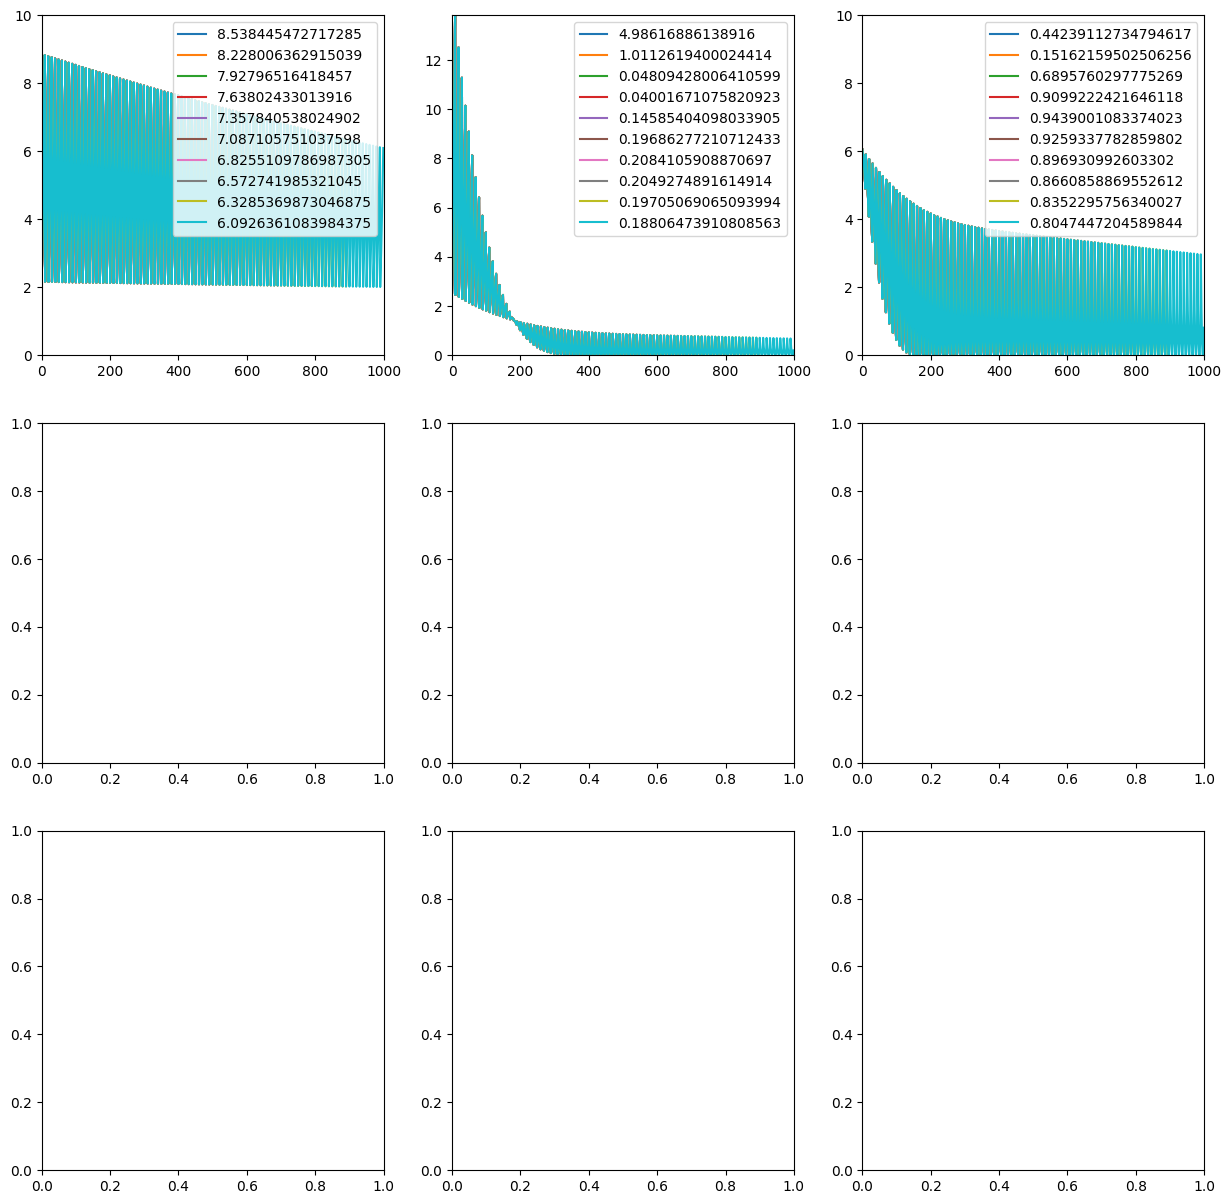

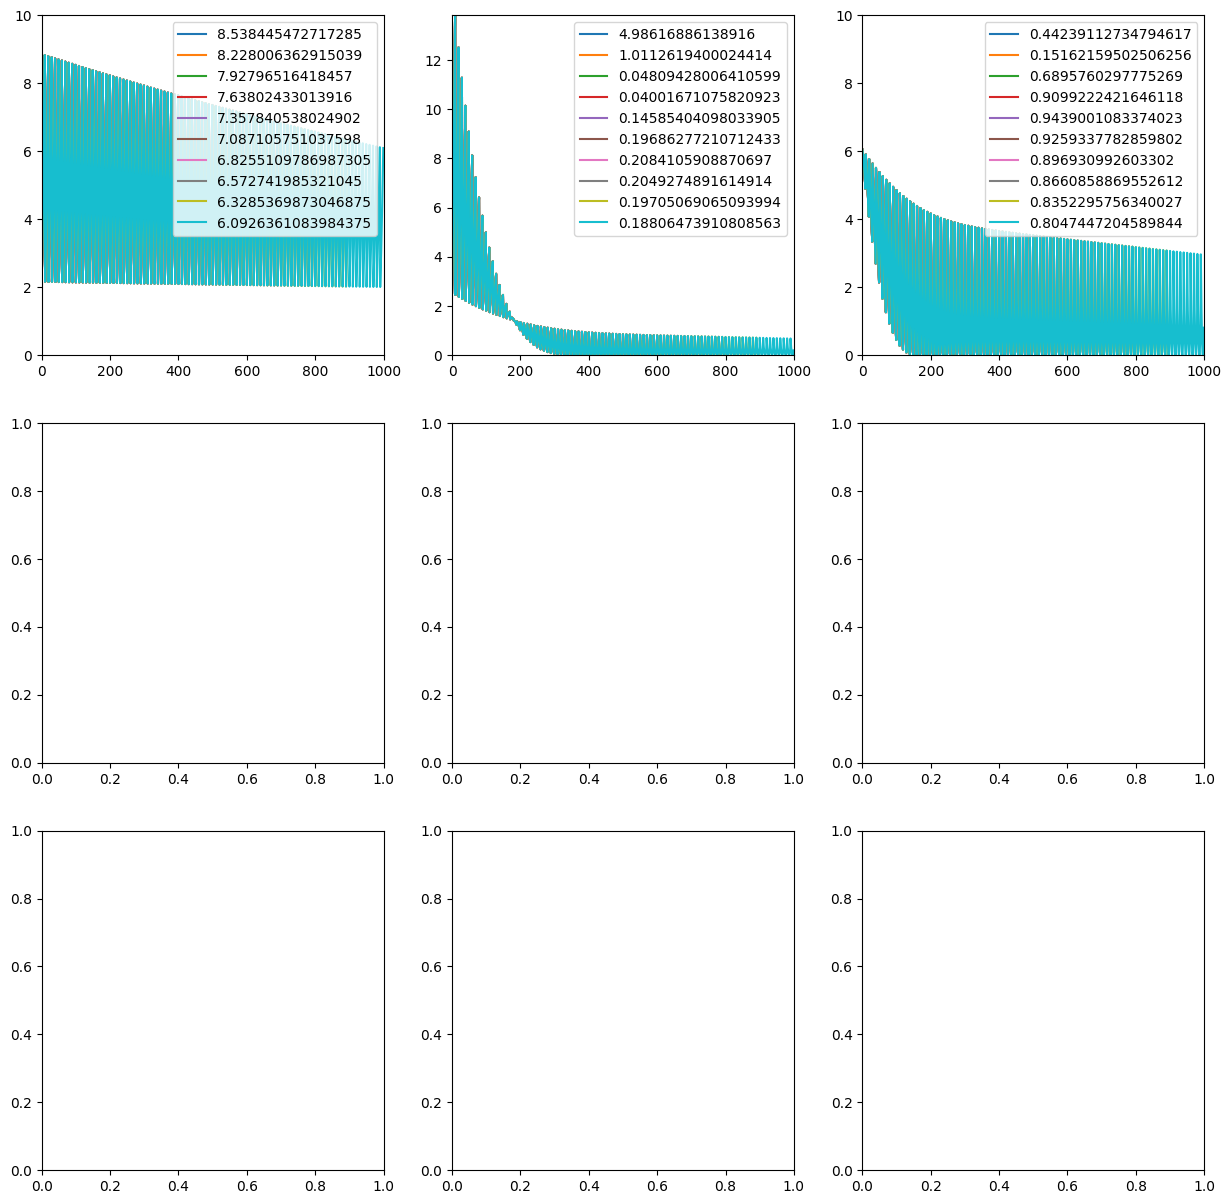

In [36]:
compare_9_models([lin_1_trainer,lin_2_trainer,lin_3_trainer])

<div dir="rtl" lang="he" xml:lang="he">

# תוכנית למידה - _lr schedule_


לעתים נרצה לשנות את הערך של ה
_lr_ 
במהלך אימון התוכנה. 
הכלים האלה נקראים 
_lr schedule_ 
כמו שמעדכנים את משקולות המודל ע"י 
`optimazer.step()`
ניתן גם לעדכן את ערכי הלמידהה ע"י 
`schedule.step()`


In [ ]:
torch.optim.lr_scheduler.ReduceLROnPlateau
